# A guided project from dataquest

This is a dataquest mission part of the course I'm doing to become a data scientist. You can find the solutions that [dataquest.io]() prepared in the github [repo](https://github.com/dataquestio/solutions/blob/master/Mission217Solutions.ipynb).

Here's what I did! Feel free to get in touch with comments, questions and feedback!

# Read in the data

In [2]:
import pandas as pd
import numpy
import re


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

There are several features that correlate highly with `sat_score`. In terms of students ethnicity, we can see easily that hispanic and black students perform a lot worse than asian or white students.

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

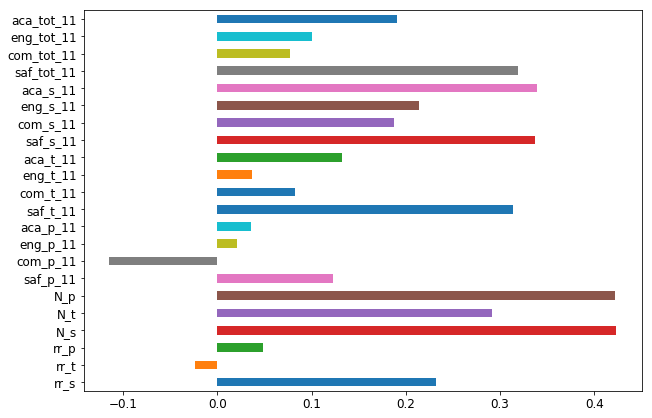

In [13]:
fig, ax = plt.subplots(figsize = (10,7))
combined.corr()["sat_score"][survey_fields].plot.barh()
ax.tick_params(labelsize=12)
# I prefer in this case an horizontal bar plot so it's easier 
# to read the features

There are several features that correlate with `sat_score`, as we mentioned before.

The number of respondents `N_p` and `N_s` (Number of parent respondents and Number of student respondents, respectively), for instance. 

Now, this is not so significant or interesting, in principle.

It's worthwhile to study in some more detail the correlation with `saf` features, which relate to 'Safety and Respect'.


In particular, `saf_s_11` is 'Safety and Respect score based on student responses' and `saf_t_11` is 'Safety and Respect score based on teachers responses'. So let's explore this.


## Exploring Safety and Respect scores (saf)

Text(0,0.5,'sat_score')

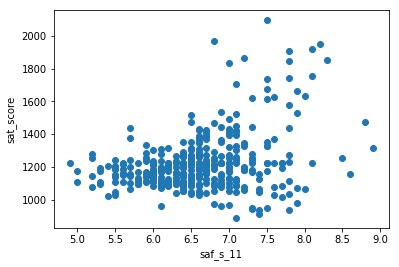

In [14]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.xlabel('saf_s_11')
plt.ylabel('sat_score')

Students from schools with a relatively high SAT score (above 1500) have a low Safety and Respect score.

Students at schools that perform well (the small amoung of dots in the upper right zone), have a high Safety and Respect score.

By contrast, students from low scoring schools have a low Safety and Respect score.

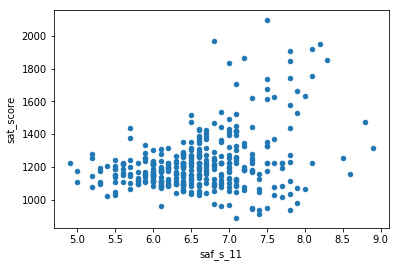

In [15]:
#we can also use the formula dataframe.plot.scatter('column_x', 'column_y')
combined.plot.scatter("saf_s_11", "sat_score")


## Let's explore Safety and Respect scores

In [16]:
average = combined.groupby("school_dist").agg(numpy.mean)
average.reset_index(inplace=True)
average.head(2)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386


In [17]:
from mpl_toolkits.basemap import Basemap

/Users/nahusznaj/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/nahusznaj/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/nahusznaj/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


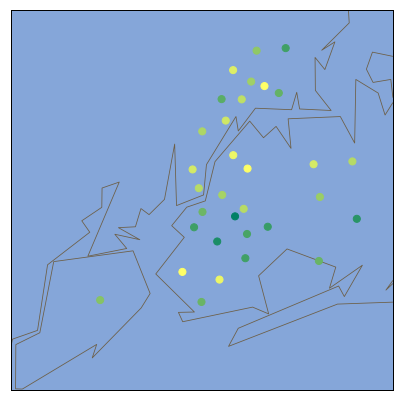

In [18]:
fig, ax = plt.subplots(figsize = (10,7))


m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.8)

longitudes = average['lon'].tolist()
latitudes = average['lat'].tolist()

m.scatter(longitudes,latitudes, s=50, zorder = 2,
          latlon = True, c = average['saf_s_11'],
          cmap = 'summer') #m.scatter(x, y, size 30
            # for better sized points, the zorder so that the
            # dots are on top of the map and not underneath, 
            # and the latlot in True so that scatter knows that x 
            # and y are longitudes and latitudes and not x,y coordinates

#in this case I added a colour map: with cmap = summer and  the c kwarg 
# argument being the series 'saf_s_11', the result will be that school 
# with a high saf (remember: Safety and Respect scores from students)
# as yellow, and a school with a low saf as green. 

Green is at the bottom end of the summer scale and yellow at the top. This means that Brooklyn and some parts of the Bronx have high safety and respect scores from students, while Manhattan and Queens have lower scores.

See the colour references in this link https://matplotlib.org/examples/color/colormaps_reference.html

## Ethnic groups and SAT scores

As mentioned before, we can see from the correlations with `sat_score` that hispanic and black students perform a lot worse than asian or white students. Let's run some visual representations of this.

Let's first focus the correlation with `sat_score` that we pulled earlier on the ethnicity.

In [19]:
ethnics = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

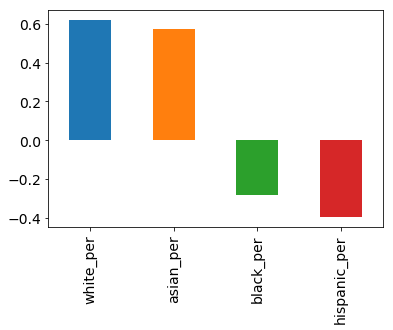

In [20]:
combined.corr()["sat_score"][ethnics].plot.bar()
plt.tick_params(labelsize=14)

It's clear that hispanic ethnic group is the one that correlates worse with `sat_score`, that is, the lower the score the higher the percentage of hispanic pupils.

Let's define that SAT score below 1000 is a low one and above 1000 a high SAT score.

In [21]:
low_sat_score = combined[combined['sat_score'] < 1000]
high_sat_score = combined[combined['sat_score'] >= 1000]

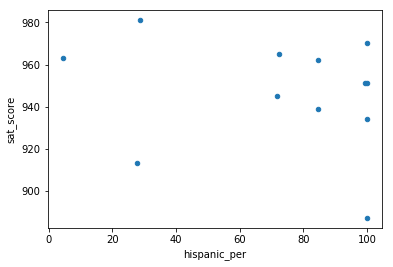

In [22]:
low_sat_score.plot.scatter('hispanic_per', 'sat_score')

In [23]:
low_sat_score['SCHOOL NAME']

91                  INTERNATIONAL COMMUNITY HIGH SCHOOL
125                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                     BRONX INTERNATIONAL HIGH SCHOOL
139               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                       HIGH SCHOOL OF WORLD CULTURES
188                  BROOKLYN INTERNATIONAL HIGH SCHOOL
225       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
237                          IT TAKES A VILLAGE ACADEMY
253                           MULTICULTURAL HIGH SCHOOL
286              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [24]:
high_hispanic = combined[combined['hispanic_per'] >= 95]


In [25]:
print(high_hispanic['SCHOOL NAME'])

print(high_hispanic['ell_percent'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object
44     72.6
82     19.6
89     89.6
125    86.6
141    79.9
176    92.9
253    94.6
286    91.3
Name: ell_percent, dtype: float64


Wow! All schools in NYC with most students being hispanic have a pretty low score.

These schools have pupils who are still learning English as a second language, this may explain why they do not perform well in SAT.

In [26]:
low_hispanic = combined[combined['hispanic_per'] < 20]
low_hispanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 4 to 356
Columns: 160 entries, DBN to school_dist
dtypes: float64(51), int64(16), object(93)
memory usage: 108.2+ KB


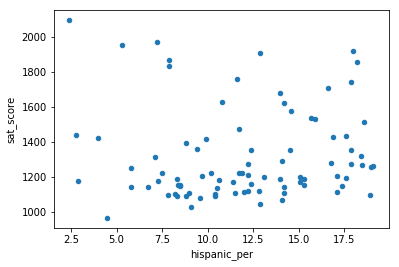

In [27]:
low_hispanic.plot.scatter('hispanic_per', 'sat_score')

On the contrary, schools with a low percentage of hispanic pupils have various scores.

Let's look at schools with high score and low population of hispanic pupils:

In [28]:
high_sat_low_hispanic =  combined[(combined['hispanic_per'] < 10) 
                                  & (combined['sat_score'] > 1800) ]
print(high_sat_low_hispanic['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


There are only 5 schools with a low percentage of hispanic origin students and high score.

We could look up each school to see whether there's a common characteristig. Indeed, these schools select only the best students so that's why they have a high score. 

## Let's look at gender

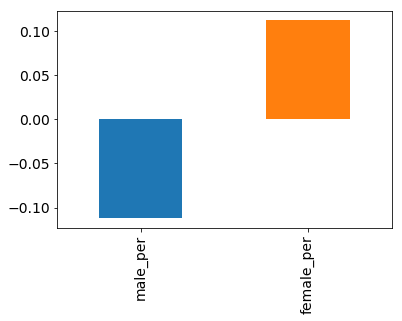

In [29]:
combined.corr()["sat_score"][['male_per', 'female_per']].plot.bar()
plt.tick_params(labelsize=14)

There is no strong correlation in terms of gender, although female positively correlates with SAT score  while males correlate negatively.

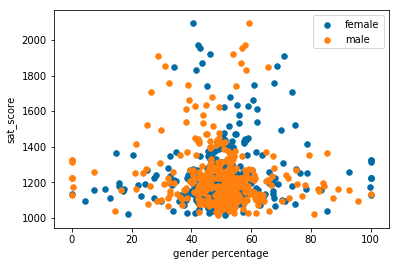

In [30]:
fig, ax = plt.subplots()

cb_dark_bluecb_dark  = (0/255,107/255,164/255)
cb_orange = (255/255, 128/255, 14/255)

high_sat_score.plot.scatter('female_per', 
                            'sat_score', 
                            c = cb_dark_bluecb_dark, 
                            ax = ax,
                            label = 'female',
                           s = 30)
high_sat_score.plot.scatter('male_per', 
                            'sat_score', 
                            c = cb_orange, 
                            ax = ax,
                           label = 'male',
                           s = 30)
ax.set_xlabel('gender percentage')
ax.legend()

There doesn't seem to be a correlation between gender population and sat performance.

There seems to be the case that schools with a highly predominant gender population have a low SAT score.

While schools with the high scores tend to be more balanced in terms of gender 40 - 60 %.

Let's look at schools with a high percentage of female pupils and high SAT score.

In [31]:
high_female = combined[(combined['female_per'] > 60) &
                       (combined['sat_score'] > 1700)]

In [32]:
high_female['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## Advanced Placement exams

In the USA, high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

Because total_enrollment is highly correlated with sat_score, as we mentined above, we want to filter this. Hence, we'll calculate the percentage of students in each school who took at least one AP exam.

In [33]:
combined['ap_per'] = 100* combined['AP Test Takers ']/combined['total_enrollment']


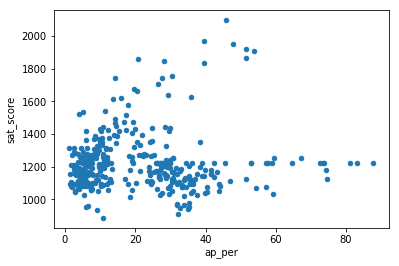

In [34]:
combined.plot.scatter('ap_per', 'sat_score')

There isn't a strong tendency here, but it is noteworthy that scools with a high percentage of pupils that take AP exam have a relatively low SAT score.